# Movies recommender

The goal of this notebook is to build a simple chat bot with 3 types of recommender systems: 

* Popularity 
* Item-based with correlation
* User-based with cosine similarity

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

movies = pd.read_csv('../data/ml-latest-small/movies.csv')
ratings = pd.read_csv('../data/ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Popularity based

### Model creation

In [12]:
# get a dictionary of item id to movie title
dictionary = movies.filter(['movieId','title']).drop_duplicates()

def item_to_movie_title(item_ids: list, dictionary=dictionary):
    """
    Given a list of item ids, return a list of the corresponding 
    movie titles.
    """
    return (
    dictionary
        .query('movieId == @item_ids')
        ['title'].tolist()
    )

def dense_df_preparation(data: pd.DataFrame): 
    """
    Given a dataframe, check if the df only contains three columns. If so, 
    return a df with renamed columns in the following way: 
        ['user','item','rating']

    In case it contains more than three columns, return false
    Example: movies ratings only should include columns userId,	movieId and rating, sorted in that way. 
    """
    # quick check number of columns
    if len(data.columns) != 3: 
        print("""
            Be sure to have added a dataframe with only the columns: 
                users, items and ratings
            They have to be sorted in the same way!
        """)
        return False

    # define column names
    data.columns = ['user','item','rating']

    return data

def popularity_recommender(data: pd.DataFrame, min_n_ratings=100, n_pop_movies=5):
    """
    Given a dense dataframe and a minimum number of ratings, return
    a dataframe with the highest rated films on average. 

    FURTHER IMPROVEMENTS: 
    The popularity-based recommender should include, at least, all of 
    these genres:
        Comedy
        Drama
        Thriller
        Sci-Fi
        Children
    The similarity-based recommender should include, at least, 
    two movies that share a genre with the inputted one.
    """
    # prepare our dense matrix
    dense_df = dense_df_preparation(data)
    # in case there is a problem, stop the recommender
    if dense_df is False: 
        return
    # find most popular movies
    recommended_movies = (
    dense_df
        # find the average rating and total number of ratings 
        # by each movie
        .groupby('item')
        .agg(
            avg_rating = ('rating','mean'),
            count = ('item','count')
            )
        # exclude all movies not having a minimum number of ratings
        # defined on the parameters of the function
        .query('count > @min_n_ratings')
        # sort ratings from higher to lower
        .sort_values('avg_rating', ascending=False)
        # number of most popular movies to return
        .head(n_pop_movies)
        .reset_index()
        # remove innecessary decimals on the average rating
        .assign(avg_rating = lambda x: round(x['avg_rating'], 2))
    )

    return recommended_movies

popular_movies = popularity_recommender(ratings.drop(columns='timestamp'))
popular_movies

,item,avg_rating,count
0,318,4.43,317
1,858,4.29,192
2,2959,4.27,218
3,1221,4.26,129
4,48516,4.25,107


### Implementation: Popularity chat bot

In [3]:
def popularity_chat_bot(): 
    print("Hi! I'm your personal recommender. Let me recommend you a film!.")
    # execute recommender
    recommendations = popularity_recommender(ratings.drop(columns='timestamp'))
    # get movie title
    popular_movie = item_to_movie_title(recommendations['item'].tolist())[0]
    print(f"You will probably like {popular_movie}")
    
popularity_chat_bot()

Hi! I'm your personal recommender. Let me recommend you a film!.
You will probably like Shawshank Redemption, The (1994)


## Item-based

The goal of the item-based recommender is that given a movie title, recommend me a similar movie. 

To achieve this goal, we are going do define some rules: 

* As the user will not know the move id, will have to find ask to introduce the movie title.
* It is very likely that the movie titel will note be exactly as the one we have, so our function has to be flexible enough to find a title containing what the user is looking for. 
* To define which movie is similar to another, we will look for the correlationbetween the movies. 

### Model creation

#### Create the movie finder function

In [10]:
def movie_id_finder(): 
    """
    Given a title, find the closest movie title and return its id
    """
    # insert a movie title    
    title = input().lower()
    # look if there is any movie containing this title, if so, filter them
    fitlered_movies = (
    dictionary
        .assign(check = lambda x: x['title'].str.lower().str.contains(title))
        .query('check')
        .sort_values('title')
    )
    # if there are multiple movies containing the same title, ask to which 
    # one is the user refering. Once it is specified, filter all the others out
    if fitlered_movies.shape[0] > 1: 
        print("Which one of the following movies do you mean? ")
        n_movie = 1
        movies_titles = fitlered_movies['title'].tolist()
        for movie in movies_titles: 
            print("\t" + movie + " [type " + str(n_movie) + "]")
            n_movie += 1
        # ask about the movie
        n_movie = input()
        selected_title = movies_titles[int(n_movie) - 1]
        fitlered_movies = fitlered_movies.query('title == @selected_title')
    # if there is no movies with that title, return False
    elif fitlered_movies.shape[0] == 0: 
        print('No movies has been found')
        return False
    # inform about the movie selected
    print(f"The selected movie is {fitlered_movies['title'].values[0]}")
    return fitlered_movies['movieId'].values[0]

# movie_id_finder()

#### Item-based recommender

In [5]:
def sparse_df_preparation(data: pd.DataFrame): 
    """
    Given a data return an sparse matrix with index user, columns items
    and values rating
    """
    # prepare our dense matrix
    dense_df = dense_df_preparation(data)
    # in case there is a problem, stop the recommender
    if dense_df is False: 
        return False
    # create the sparsed dataframe
    sparse_df = dense_df.pivot('user','item','rating')

    return sparse_df

import warnings

def item_based_recommender(data: pd.DataFrame, item, n=5):
    """
    Given a data and an item id, return the n most correlated items 

    FURTHER IMPROVEMENT: 
    Need to select only items that has a descent number of reviews to avoid 
    higher correlations with movies that have few reviews. 
    """ 
    # get the sparsed matrix
    sparse_df = sparse_df_preparation(data)
    if sparse_df is False: 
        return
    # do not show warnings
    warnings.filterwarnings('ignore')
    # use the pairwise function to find the most correlated movies to 
    # the movie we specified
    correlated_items = sparse_df.corrwith(sparse_df[item])
    # check if there is no correlation to any other film, if so, 
    # return a message
    if np.isnan(correlated_items.values).all(): 
        print('No correlation with any other film!')
        return
    # if there is correlation with other movies:
    else: 
        top_corr_item = (
        correlated_items
            # sort them from the highest correlated to the lowers
            .sort_values(ascending=False)
            .reset_index()
            # filter the same movie
            .query('item != @item')
            # select the top n correlated movies
            .head(n)            
            )
         # return the column item and transform it into a list
        return top_corr_item['item'].tolist()

# movie_id = 6377
# recommended_items = item_based_recommender(
#     ratings.drop(columns='timestamp'), item=movie_id, n=5)

# item_to_movie_title(recommended_items)

### Implementation: Item-based chat bot

In [263]:
def item_based_chat_bot(): 
    print("Hi! I'm your personal recommender. Tell me a film you've liked.")
    # help user to find the movie name
    movie_id = movie_id_finder()
    # find out the most correlated films to the given movie id
    recommendations = item_based_recommender(
        ratings.drop(columns='timestamp'), item=movie_id)
    if not recommendations: 
        return
    # get top movie title
    recommended_movie = item_to_movie_title(recommendations)[0]
    print(f"You will probably like {recommended_movie}")
    
item_based_chat_bot()

Hi! I'm your personal recommender. Tell me a film you've liked.
Which one of the following movies do you mean? 
	Bridget Jones's Baby (2016) [type 1]
	Bridget Jones's Diary (2001) [type 2]
	Bridget Jones: The Edge of Reason (2004) [type 3]
The selected movie is Bridget Jones's Diary (2001)
You will probably like War Room, The (1993)


## User-based

Steps to build a user based recommender system:
    
1. We know the items that all users have rated and the ones that have not and if they like or not (value of the rating).
2. Based on that info, I can look at how similar one student is to the others. To achieve it, we can use the cosine distance. It will return us a value between 0 and 1; 0 will be closer to our user, and 1 would be far away from our user. To transform them as a similitude metric, we can apply: $cosine\ similitude = 1 - cosine\ distance$. Then the users closer to each other will have a value closer to 1, and the other will be closer to 0. To know more information about cosine distance, I recommend to watch the following [video](https://www.youtube.com/watch?v=ieMjGVYw9ag).

3. Once we have found the most similar user, we will ponderate the results to see which item has not been seen by our user that is closer to its ratings. 


## Model creation

#### Split the sparsed matrix between train and test

In [265]:
from sklearn.model_selection import train_test_split

def train_test_creation(data, random_state=1, train_size=.8):
    """
    Given a ratings data, transform it into a sparse matrix and return
    a train, test, train_pos, test_pos (in that order)
    """
    # create the sparse matrix
    sparse_df = sparse_df_preparation(data)
    # locate all positions with a rating
    ratings_pos = pd.DataFrame(
        # find all the positions different than missing values
        # 1. transform the sparse matrix into a numpy array
        # 2. the ~ operator help us to define "not". If we combine it with 
        #   np.isnan we are saying "is not nan"
        # 3. np.argwhere help us to find the positions with the argument 
        #   we are looking for in an array. In that case is all the non 
        #   nan positions in our array
        np.argwhere(~np.isnan(np.array(sparse_df)))
    ) # np.argwhere(a) is almost the same as np.transpose(np.nonzero(a)), 
    # but produces a result of the correct shape for a 0D array.
    # Source: numpy documentation

    train_pos, test_pos = train_test_split(
        ratings_pos, random_state=random_state, train_size=train_size)

    # create an empty dataframe full of 0, with the same shape as the sparse_df data
    train = np.zeros(sparse_df.shape)
    # fill the set with the sparse_df ratings based on the train positions
    for pos in train_pos.values: 
        index = pos[0]
        col = pos[1]
        train[index, col] = sparse_df.iloc[index, col]
    train = pd.DataFrame(
        train, 
        columns=sparse_df.columns, 
        index=sparse_df.index
        )

    # now it is time for the test set. We will follow the same process
    test = np.zeros(sparse_df.shape)
    for pos in test_pos.values: 
        index = pos[0]
        col = pos[1]
        test[index, col] = sparse_df.iloc[index, col]
    test = pd.DataFrame(
        test, 
        columns=sparse_df.columns, 
        index=sparse_df.index
        )

    return train, test, train_pos, test_pos

rdy_rat = ratings.drop(columns='timestamp')
train, test, train_pos, test_pos = train_test_creation(rdy_rat)

### Find all the user similitudes with the train sparsed data

In [266]:
from sklearn.metrics.pairwise import cosine_similarity
# train the model
train_similitudes = pd.DataFrame(
    cosine_similarity(train), 
    columns=train.index, index=train.index
    )

### Create our recommender

In [267]:
def user_based_recommender(index_name, column_name, sim_df, sparse_df): 
    results = (
    pd.DataFrame({
        'ratings': sparse_df.loc[:,column_name], 
        'similitudes' : sim_df.loc[index_name,:].tolist()
    })
        .query('ratings != 0')
        .assign(weighted_ratings = lambda x: x.ratings * x.similitudes)
        .agg({
            'weighted_ratings':'sum', 
            'similitudes':'sum'
        })
    )
    pred_rating = (results['weighted_ratings'] / results['similitudes'])
    return pred_rating
# user_based_recommender(353, 6416, train_similitudes, test)

### Model evaluation

In [268]:
def round_off_rating(number):
    """Round a number to the closest half integer.
    >>> round_off_rating(1.3)
    1.5
    >>> round_off_rating(2.6)
    2.5
    >>> round_off_rating(3.0)
    3.0
    >>> round_off_rating(4.1)
    4.0"""
    return round(number * 2) / 2

predictions = [
    round_off_rating(
        user_based_recommender(
            test.index[pos[0]], test.columns[pos[1]], train_similitudes, test
            )
        ) 
    for pos in test_pos.values]
true_values = [test.iloc[pos[0],pos[1]] for pos in test_pos.values]


        MSE: 0.29694317731059106
        RMSE: 0.544924928142025
        MAE: 0.3507784609282031
        MAPE: 0.1473720548975904
        
Head() plot data:
   preds  true  count_perc
0    0.5   0.5  100.000000
1    1.0   0.5   25.000000
2    1.0   1.0   75.000000
3    1.5   0.5   14.626866
4    1.5   1.0   45.074627
5    1.5   1.5   35.522388
6    1.5   2.0    4.776119
7    2.0   0.5    5.529954
8    2.0   1.0   15.437788
9    2.0   1.5   11.290323


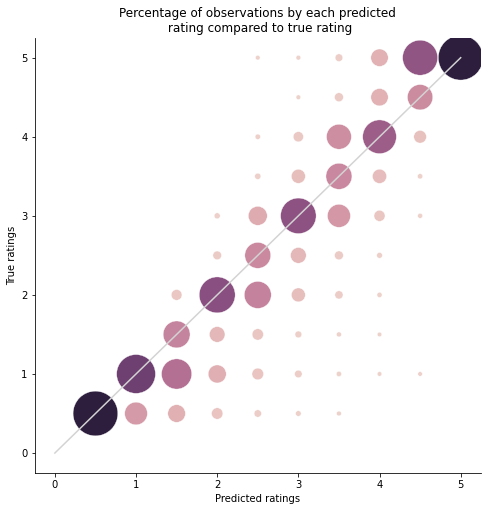

In [269]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
def predictions_analysis(y_true, preds): 
    print(
        f"""
        MSE: {mean_squared_error(y_true, preds)}
        RMSE: {mean_squared_error(y_true, preds)**0.5}
        MAE: {mean_absolute_error(y_true, preds)}
        MAPE: {mean_absolute_percentage_error(y_true, preds)}
        """
    )

    p_df = (
    pd.DataFrame({
        'preds':preds, 
        'true':y_true
        })
        .groupby(['preds','true'])['preds']
        .count()
        .groupby(level=0)
        .apply(lambda x: 100 * x / float(x.sum()))
        .reset_index(name='count_perc'))#.reset_index(name='count')
    print('Head() plot data:')
    print(p_df.head(10))
    plt.subplots(figsize=(8, 8))
    sns.scatterplot(
        data=p_df, x='preds',y='true', 
        size='count_perc', hue='count_perc', sizes=(20, 2000)
        )
    sns.lineplot(x=[0,5], y=[0,5], color='lightgrey')
    plt.title('Percentage of observations by each predicted\n rating compared to true rating')
    plt.xlabel('Predicted ratings')
    plt.ylabel('True ratings')
    plt.legend([],[], frameon=False)
    sns.despine()
    plt.show()

predictions_analysis(true_values, predictions)

A further improvement would be to try to predict our ratings only to the most similiar users (define a number of neighbours to look at).

### User-based recommender creation

In [270]:
import sys
def get_user_based_recommendations(data, user, top_n=5):
    """
    Given the rating data and a user id, return the top n films

    FURTHER IMPROVEMENT: 
    * Increase the performance by excluding all the films with a low
    number of ratings. An option would be to combine the popular and user-based recommender.
    """
    # get the sparse matrix
    sparse_df = sparse_df_preparation(data).replace(np.nan, 0)
    if user not in sparse_df.index: 
        print('User not found!')
        return False
    # calculate the similitude matrx with cosine strategy
    similitudes_df = pd.DataFrame(
        cosine_similarity(sparse_df), 
        columns=sparse_df.index, index=sparse_df.index
        )
    # find out the non rated movies by our user
    non_rated_movies = (
        sparse_df
        .loc[user, :]
        .reset_index(name='user_rating')
        .query('user_rating == 0')
        )
    # find the predictied for each non rated film
    # display a nice progress bar to know how the process is going
    pred_rat = []
    i = 0
    n=len(non_rated_movies['item'])
    for item in non_rated_movies['item'].tolist():
        pred_rat.append(
            user_based_recommender(user, item, similitudes_df, sparse_df)
            )
        # progress bar
        sys.stdout.write('\r')
        j = (i + 1) / n
        sys.stdout.write("[%-20s] %d%%" % ('='*int(20*j), 100*j))
        sys.stdout.flush()
        i+=1
    # add the predicted ratings and sort them
    top_pred_ratings = (
    non_rated_movies
        .assign(pred = pred_rat)
        .sort_values('pred', ascending=False)
        .head(top_n)
        )
    # return a list of the movies id with a higer predicted rating
    return top_pred_ratings['item'].tolist()

# recommendations = get_user_based_recommendations(rdy_rat, 70)
# item_to_movie_title(recommendations)

## Model Implementation

Time to create our chat bot

In [271]:
def user_based_chat_bot(): 
    print("Hi! I'm your personal recommender. Can you remember me your user id?")
    # help user to find the movie name
    user_id = int(input())
    # find out the most correlated films to the given movie id
    print('Based on your previous ratings, let me recommend you one film!')
    recommendations = get_user_based_recommendations(
        ratings.drop(columns='timestamp'), 
        user=user_id,
        top_n=1)
    if not recommendations: 
        return
    # get top movie title
    recommended_movie = item_to_movie_title(recommendations)[0]
    print(f"\nYou will probably like {recommended_movie}")
    
user_based_chat_bot()

Hi! I'm your personal recommender. Can you remember me your user id?
Based on your previous ratings, let me recommend you one film!
[====================] 100%
You will probably like Going Places (Valseuses, Les) (1974)
